<a href="https://colab.research.google.com/github/ED19841002/testrepo/blob/main/Merck_Molecular_Activity_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [17]:



#Cell 1: run every time


# ✅ Enable Full CPU Power & Parallel Processing in Google Colab


import os

import numpy as np

import pandas as pd

import json

import joblib  # ✅ For saving models efficiently

import zipfile

import time

import gc

import matplotlib.pyplot as plt

import seaborn as sns


from joblib import parallel_backend

from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import ElasticNet

from xgboost import XGBRegressor

import lightgbm as lgb

from sklearn.metrics import r2_score, mean_squared_error

from scipy.stats import zscore

from scipy.stats.mstats import winsorize




import torch

if torch.cuda.is_available():

    device = torch.device("cuda")

else:

    device = torch.device("cpu")


print(f"✅ Using device: {device}")


# ✅ Set up environment variables for performance optimization

NUM_THREADS = min(12, os.cpu_count())

os.environ["OMP_NUM_THREADS"] = str(NUM_THREADS)

os.environ["MKL_NUM_THREADS"] = str(NUM_THREADS)

os.environ["OPENBLAS_NUM_THREADS"] = str(NUM_THREADS)

os.environ["VECLIB_MAXIMUM_THREADS"] = str(NUM_THREADS)

os.environ["NUMEXPR_NUM_THREADS"] = str(NUM_THREADS)


print(f"✅ Using {NUM_THREADS} CPU threads for parallel processing.")


# ✅ Mount Google Drive

from google.colab import drive

drive.mount('/content/drive')


# ✅ Set base directories

base_dir = "/content/drive/My Drive/Colab Notebooks/Merck_Data"

data_dir = os.path.join(base_dir, "raw_data")  # Where the original ZIP file is stored

processed_dir = os.path.join(base_dir, "processed_data")  # Where processed data will be stored


# ✅ Create directories if they don't exist

os.makedirs(data_dir, exist_ok=True)

os.makedirs(processed_dir, exist_ok=True)


# ✅ Print directory paths

print(f"🔹 Base Directory: {base_dir}")

print(f"🔹 Raw Data Directory: {data_dir}")

print(f"🔹 Processed Data Directory: {processed_dir}")

✅ Using device: cpu
✅ Using 2 CPU threads for parallel processing.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔹 Base Directory: /content/drive/My Drive/Colab Notebooks/Merck_Data
🔹 Raw Data Directory: /content/drive/My Drive/Colab Notebooks/Merck_Data/raw_data
🔹 Processed Data Directory: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data


In [2]:
#CELL 2

# ✅ Run this every time


# ✅ Path to ZIP File (already stored in Google Drive)

zip_file = os.path.join(data_dir, "MerckActivity.zip")


if not os.path.exists(zip_file):

    raise FileNotFoundError(f"❌ ERROR: {zip_file} not found in Google Drive! Ensure it's correctly uploaded.")


# ✅ Extract the main ZIP file if not already extracted

if not os.path.exists(os.path.join(data_dir, "TrainingSet")):

    with zipfile.ZipFile(zip_file, "r") as zip_ref:

        zip_ref.extractall(data_dir)

    print("✅ MerckActivity.zip extracted successfully!")


# ✅ Extract TrainingSet.zip & TestSet.zip

for sub_zip in ["TrainingSet.zip", "TestSet.zip"]:

    sub_zip_path = os.path.join(data_dir, sub_zip)

    sub_extract_path = os.path.join(data_dir, sub_zip.replace(".zip", ""))


    if os.path.exists(sub_zip_path) and not os.path.exists(sub_extract_path):

        with zipfile.ZipFile(sub_zip_path, "r") as zip_ref:

            zip_ref.extractall(data_dir)

        print(f"✅ {sub_zip} extracted successfully!")


# ✅ Define directories

trainset_dir = os.path.join(data_dir, "TrainingSet")

testset_dir = os.path.join(data_dir, "TestSet")


# ✅ Save training filenames to JSON

train_files = sorted([f for f in os.listdir(trainset_dir) if f.endswith(".csv")])

test_files = sorted([f for f in os.listdir(testset_dir) if f.endswith(".csv")])


train_files_path = os.path.join(processed_dir, "train_files.json")


with open(train_files_path, "w") as f:

    json.dump(train_files, f)


print(f"\n✅ Found {len(train_files)} training files and {len(test_files)} test files.")


✅ Found 15 training files and 15 test files.


In [3]:
#CELL 3


# ✅ Run this every time after first run


train_files_path = os.path.join(processed_dir, "train_files.json")

with open(train_files_path, "r") as f:

    train_files = json.load(f)

In [ ]:
#CELL 4

# ✅ Run only the first time


# ✅ Path to store n_components results

n_components_path = os.path.join(processed_dir, "n_components.json")


if os.path.exists(n_components_path):

    print("✅ `n_components.json` already exists. Skipping recalculation.")

else:

    print("🔹 Calculating optimal `n_components` for each dataset...")


    n_components_dict = {}


    for file in train_files:

        dataset_name = file.replace(".csv", "")  # Extract dataset name

        print(f"🔹 Processing {dataset_name}...")


        csv_path = os.path.join(trainset_dir, file)


        if os.path.exists(csv_path):

            print(f"✅ Found {csv_path}, loading data...")

            df = pd.read_csv(csv_path)


            # ✅ Keep only numeric columns (remove MOLECULE ID)

            df = df.select_dtypes(include=[np.number])

            # ✅ Remove rows that contain only zeros

            df = df[(df != 0).any(axis=1)]

            # ✅ Drop completely zero columns

            df = df.loc[:, (df != 0).any(axis=0)]


            # ✅ Convert int64 → int32 & float64 → float32 for memory efficiency

            for col in df.columns:

                if df[col].dtype == np.int64:

                    df.loc[:, col] = df[col].astype(np.int32)

                elif df[col].dtype == np.float64:

                    df.loc[:, col] = df[col].astype(np.float32)


            # ✅ Fill NaN values with column median

            df.fillna(df.median(), inplace=True)

            # ✅ Separate features and target
            X = df.drop(columns=["MOLECULE", "Act"], errors="ignore")
            y = df["Act"] if "Act" in df.columns else None

            # ✅ Scale data
           # scaler = StandardScaler()  #Scaling produces worse results
           # X_scaled = scaler.fit_transform(X)

            # ✅ Convert DataFrame to NumPy array

            X = df.to_numpy(dtype=np.float32)


            # ✅ Apply PCA to find optimal number of components

            pca = PCA()

            pca.fit(X)


            explained_variance = np.cumsum(pca.explained_variance_ratio_)

            optimal_n = np.where(explained_variance >= 0.95)[0][0] + 1  # +1 because indexing starts at 0


            # ✅ Store optimal n_components

            n_components_dict[dataset_name] = int(optimal_n)  # Convert to Python int


            print(f"✅ Optimal `n_components` for {dataset_name}: {optimal_n}")


    # ✅ Save n_components results to JSON

    with open(n_components_path, "w") as f:

        json.dump(n_components_dict, f)


    print("\n✅ `n_components.json` saved successfully!")

🔹 Calculating optimal `n_components` for each dataset...
🔹 Processing ACT10_competition_training...
✅ Found /content/drive/My Drive/Colab Notebooks/Merck_Data/raw_data/TrainingSet/ACT10_competition_training.csv, loading data...
✅ Optimal `n_components` for ACT10_competition_training: 151
🔹 Processing ACT11_competition_training...
✅ Found /content/drive/My Drive/Colab Notebooks/Merck_Data/raw_data/TrainingSet/ACT11_competition_training.csv, loading data...
✅ Optimal `n_components` for ACT11_competition_training: 220
🔹 Processing ACT12_competition_training...
✅ Found /content/drive/My Drive/Colab Notebooks/Merck_Data/raw_data/TrainingSet/ACT12_competition_training.csv, loading data...
✅ Optimal `n_components` for ACT12_competition_training: 205
🔹 Processing ACT13_competition_training...
✅ Found /content/drive/My Drive/Colab Notebooks/Merck_Data/raw_data/TrainingSet/ACT13_competition_training.csv, loading data...
✅ Optimal `n_components` for ACT13_competition_training: 164
🔹 Processing AC

✅ Raw Data Loaded: Shape = (11151, 5792)
✅ Cleaned Data: Shape = (11151, 5463)


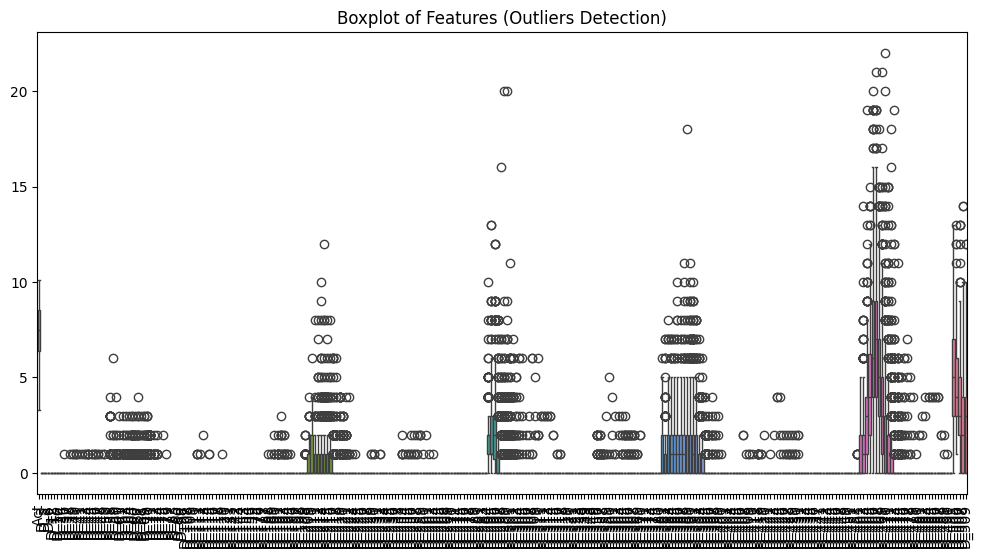


🔹 Outliers Count per Feature (Z-score > 3):
D_64     587
D_60     576
D_68     467
D_301    453
D_220    406
D_474    401
D_396    351
D_303    341
D_302    332
D_471    330
D_394    322
D_356    310
D_65     300
D_70     280
D_297    279
D_473    275
D_219    264
D_357    254
D_472    250
D_58     246
dtype: int64

🔹 Outliers Count per Feature (IQR Method) (Top 20 columns):
D_472    2742
D_298    2726
D_300    2194
D_299    2097
D_217    2004
D_473    1991
D_63     1529
D_208    1430
D_218    1430
D_294    1326
D_301    1320
D_474    1278
D_61     1260
D_65     1202
D_214     997
D_70      996
D_71      981
D_66      954
D_471     910
D_395     906
dtype: int64

🔹 Skewed Features (Skewness > 0.75) (Top 20 columns):
D_3      105.598295
D_442    105.598295
D_441    105.598295
D_437    105.598295
D_443    105.598295
D_86     105.598295
D_85     105.598295
D_108    105.598295
D_153    105.598295
D_144    105.598295
D_319    105.598295
D_318    105.598295
D_236    105.598295
D_322    105.

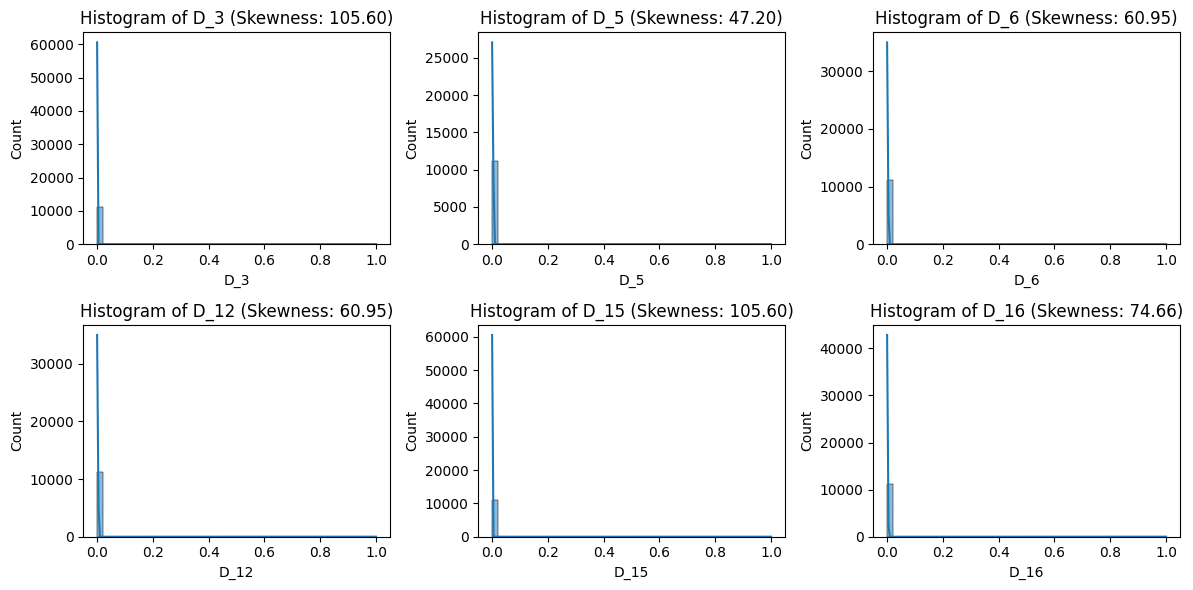

In [6]:
#CELL 7BA: Check for outliers and skewness
# Run only once (first time)


# ✅ Choose one dataset

SELECTED_DATASET = "ACT10_competition_training.csv"


# ✅ Define file path

X_path = os.path.join(trainset_dir, SELECTED_DATASET)


# ✅ Load dataset

df = pd.read_csv(X_path)


print(f"✅ Raw Data Loaded: Shape = {df.shape}")


# -----------------------------------

# 🔹 Step 1: Data Preprocessing

# -----------------------------------


# ✅ Keep only numeric columns

df = df.select_dtypes(include=[np.number])


# ✅ Remove rows that contain only zeros

df = df[(df != 0).any(axis=1)]


# ✅ Drop completely zero columns

df = df.loc[:, (df != 0).any(axis=0)]


# ✅ Convert int64 → int32 & float64 → float32 (memory optimization)

for col in df.columns:

    if df[col].dtype == np.int64:

        df.loc[:, col] = df[col].astype(np.int32)

    elif df[col].dtype == np.float64:

        df.loc[:, col] = df[col].astype(np.float32)


# ✅ Fill NaN values with column median

df.fillna(df.median(), inplace=True)


print(f"✅ Cleaned Data: Shape = {df.shape}")

# ✅ Select a subset of columns (to prevent memory overload)
NUM_COLUMNS_TO_ANALYZE = min(300, df.shape[1]) #Limit columns to analyze

df = df.iloc[:, :NUM_COLUMNS_TO_ANALYZE] # PRocess only 300 features

# -----------------------------------

# 🔹 Step 2: Check Outliers (Boxplots)

# -----------------------------------


plt.figure(figsize=(12, 6))

sns.boxplot(data=df.sample(n=min(500, df.shape[0]), axis=0)) # Show first 500 rows only

plt.xticks(rotation=90)

plt.title("Boxplot of Features (Outliers Detection)")

plt.show()


# -----------------------------------

# 🔹 Step 3: Detect Outliers (Z-Score Method)

# -----------------------------------


z_scores = np.abs(zscore(df, nan_policy="omit")) # Ignore NaNs

outlier_threshold = 3  # Outliers are values > 3 standard deviations

outlier_counts = (z_scores > outlier_threshold).sum(axis=0)


print("\n🔹 Outliers Count per Feature (Z-score > 3):")

print(outlier_counts[outlier_counts > 0].sort_values(ascending=False).head(20))


# -----------------------------------

# 🔹 Step 4: Detect Outliers (IQR Method)

# -----------------------------------


Q1 = df.quantile(0.25)

Q3 = df.quantile(0.75)

IQR = Q3 - Q1


outliers_iqr = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

outliers_iqr = outliers_iqr[outliers_iqr > 0]


print("\n🔹 Outliers Count per Feature (IQR Method) (Top 20 columns):")

print(outliers_iqr.sort_values(ascending=False).head(20))


# -----------------------------------

# 🔹 Step 5: Check Skewness

# -----------------------------------


skewness = df.skew()

skewed_features = skewness[abs(skewness) > 0.75]  # Consider skewness > 0.75


print("\n🔹 Skewed Features (Skewness > 0.75) (Top 20 columns):")

print(skewed_features.sort_values(ascending=False).head(20))


# -----------------------------------

# 🔹 Step 6: Visualize Skewed Distributions

# -----------------------------------


plt.figure(figsize=(12, 6))

skewed_cols = skewed_features.index[:6]  # Show first 6 skewed columns


for i, col in enumerate(skewed_cols, 1):

    plt.subplot(2, 3, i)

    sns.histplot(df[col], bins=50, kde=True)

    plt.title(f"Histogram of {col} (Skewness: {skewness[col]:.2f})")


plt.tight_layout()

plt.show()

As we can see from the previous sample we have a lot of outliers and skewness that will mess our R^2 and calculation time. So I should first apply Winsorization and Yeo Johnson.

In [14]:
# CELL 8BB: only one dataset with XGBoost, Winsorization and Yeo Johnson

# Run only once (first time)

os.environ["NVIDIA_VISIBLE_DEVICES"] = "0"  # Use first available GPU

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Fix potential GPU hang issues

os.environ["XGBOOST_USE_CUDA"] = "1"  # 🚀 Force GPU usage

# ✅ Choose one dataset to train

SELECTED_DATASET = "ACT10_competition_training.csv"  # Change this dataset to test different models


# ✅ Load `n_components.json`

n_components_path = os.path.join(processed_dir, "n_components.json")


if not os.path.exists(n_components_path):

    raise FileNotFoundError(f"❌ ERROR: `n_components.json` not found in {processed_dir}. Run Cell 4 first!")


with open(n_components_path, "r") as f:

    n_components_dict = json.load(f)


print("✅ Loaded `n_components.json`:", n_components_dict)


# ✅ Define file paths

dataset_name = SELECTED_DATASET.replace(".csv", "")

y_file = SELECTED_DATASET.replace(".csv", "_y.npy")  # Ensure correct target file reference


X_path = os.path.join(trainset_dir, SELECTED_DATASET)  # ✅ Load from `trainset_dir`

y_path = os.path.join(trainset_dir, y_file)  # ✅ Load from `trainset_dir`


# ✅ Check if files exist before proceeding

if not os.path.exists(X_path):

    raise FileNotFoundError(f"❌ ERROR: Feature file not found: {X_path}")


if not os.path.exists(y_path):

    raise FileNotFoundError(f"❌ ERROR: Target file not found: {y_path}")


# ✅ Load data

print(f"\n✅ Loading {SELECTED_DATASET}...")


df = pd.read_csv(X_path, encoding="ISO-8859-1").select_dtypes(include=[np.number]).drop(columns=["MOLECULE", "Act"], errors="ignore")

y = np.load(y_path)


# ✅ Winsorization (Handling Outliers)
#for col in df.columns:
#    df[col] = winsorize(df[col], limits=[0.05, 0.05]) # Capping 1st & 99th percentiles

# ✅ Yeo-Johnson Transformation (Handling Skewness)

#transformer = PowerTransformer(method='yeo-johnson', standardize=True)

#df[df.columns] = transformer.fit_transform(df[df.columns]) # Transform all numeric columns

# ✅ Convert to NumPy arrays

X = df.to_numpy(dtype=np.float32)

# ✅ Debugging: Check data shapes

print(f"✅ X.shape: {X.shape}, y.shape: {y.shape}")


# ✅ Get optimal `n_components`

n_components = n_components_dict.get(dataset_name, 300)  # Default to 300 if missing

print(f"✅ Using `n_components`: {n_components}")


# ✅ Define Pipeline

pipe = Pipeline([

    ("pca", PCA(n_components=n_components)),

    ("xgb", XGBRegressor(objective="reg:squarederror", tree_method = "hist",
                         device = "cuda", random_state=42))

])


# ✅ Define Hyperparameter Grid

param_grid = {

    "xgb__n_estimators": [500],  # Number of boosting rounds

    "xgb__max_depth": [6],  # Tree depth

    "xgb__learning_rate": [ 0.1],  # Step size shrinkage

    "xgb__subsample": [1.0],  # Fraction of samples per boosting round

    "xgb__colsample_bytree": [0.6],  # Fraction of features per tree

}


# ✅ Train/Test Split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# ✅ Grid Search with Parallel Computing

with parallel_backend("loky", n_jobs=-1):

    start_time = time.time()

    grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring="r2", n_jobs=-1, pre_dispatch="2*n_jobs", verbose=3)

    grid_search.fit(X_train, y_train)

    end_time = time.time()


elapsed_time = end_time - start_time

print(f"🕒 Time taken: {elapsed_time:.2f} seconds")


# ✅ Get Best Model

best_model = grid_search.best_estimator_


print(f"✅ Best Params: {grid_search.best_params_}")

print(f"✅ Best R² Score (Train): {grid_search.best_score_}")


# ✅ Evaluate on Validation Set

y_pred = best_model.predict(X_val)

r2_val = r2_score(y_val, y_pred)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))


print(f"✅ {dataset_name} - Best R² (Test): {r2_val:.4f}, RMSE: {rmse_val:.4f}")


# ✅ Save trained model

model_save_path = os.path.join(processed_dir, f"{dataset_name}_XGB_model.joblib")

joblib.dump(best_model, model_save_path)


print(f"💾 Model saved: {model_save_path}")


# ✅ Free memory

del X, y, X_train, X_val, y_train, y_val, y_pred, best_model, grid_search, r2_val, rmse_val

gc.collect()


print("\n✅ Training completed successfully!")

✅ Loaded `n_components.json`: {'ACT10_competition_training': 151, 'ACT11_competition_training': 220, 'ACT12_competition_training': 205, 'ACT13_competition_training': 164, 'ACT14_competition_training': 183, 'ACT15_competition_training': 184, 'ACT1_competition_training': 275, 'ACT2_competition_training': 134, 'ACT3_competition_training': 179, 'ACT4_competition_training': 89, 'ACT5_competition_training': 110, 'ACT6_competition_training': 276, 'ACT7_competition_training': 94, 'ACT8_competition_training': 130, 'ACT9_competition_training': 149}

✅ Loading ACT10_competition_training.csv...
✅ X.shape: (11151, 5790), y.shape: (11151,)
✅ Using `n_components`: 151
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:50:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:50:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


🕒 Time taken: 211.93 seconds
✅ Best Params: {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1.0}
✅ Best R² Score (Train): 0.7040397127469381
✅ ACT10_competition_training - Best R² (Test): 0.7216, RMSE: 0.7701
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT10_competition_training_XGB_model.joblib

✅ Training completed successfully!


Thus, XGBoost handles pretty well outliers and skewness, so winsorization and Yeo-Johnson are not needed!

In [ ]:


# ✅ CELL 5A: Train Random Forest with GridSearchCV


# ✅ Run if you want to try Random Forest for all datasets



# ✅ Load `n_components.json`

n_components_path = os.path.join(processed_dir, "n_components.json")


with open(n_components_path, "r") as f:

    n_components_dict = json.load(f)


print("✅ Loaded `n_components.json`:", n_components_dict)



# ✅ Define Pipeline

pipe = Pipeline([

    ("pca", PCA()),  # PCA will use dynamic n_components

    ("rf", RandomForestRegressor(n_jobs=-1, random_state=42))  # Parallel computing

])



# ✅ Define Hyperparameter Grid (Including PCA Components)

param_grid = {

    "pca__n_components": [None],  # Placeholder, will be updated dynamically

    "rf__n_estimators": [200],  # Number of trees

    "rf__max_depth": [None],  # No max depth

    "rf__min_samples_split": [2],  # Minimum samples for split

    "rf__min_samples_leaf": [1],  # Minimum samples per leaf

}



# ✅ Train models for each dataset

for file in train_files:

    dataset_name = file.replace("_X.npy", "").replace("_competition_training", "")  # Extract dataset name

    y_file = file.replace("_X.npy", "_y.npy")  # Corresponding target file


    X_path = os.path.join(trainset_dir, file)  # ✅ Load from `trainset_dir`

    y_path = os.path.join(trainset_dir, y_file)  # ✅ Load from `trainset_dir`


    if os.path.exists(X_path) and os.path.exists(y_path):

        print(f"\n🔹 Training model for {dataset_name}...")


        X = pd.read_csv(X_path, header=0)

        y = pd.read_csv(y_path, header=0)

        # ✅ Separate features and target
        X = X.drop(columns=["MOLECULE", "Act"], errors="ignore")
        y = y["Act"] if "Act" in y.columns else None


        # ✅ Convert to NumPy arrays

        X = X.to_numpy(dtype=np.float32)

        y = y.to_numpy(dtype=np.float32)


        # ✅ Get optimal `n_components`

        n_components = n_components_dict.get(file.replace(".csv", ""), 300)  # Default to 300 if missing

        param_grid["pca__n_components"] = [n_components]

        print(f"✅ Using `n_components`: {n_components}")


        # ✅ Train/Test Split

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


        # ✅ Grid Search with Parallel Computing

        with parallel_backend("loky", n_jobs=-1):
            start_time = time.time()
            grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring="r2", n_jobs=-1, pre_dispatch="2*n_jobs", verbose=1)

            grid_search.fit(X_train, y_train)

            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time taken: {elapsed_time:.2f} seconds")
        # ✅ Get Best Model

        best_model = grid_search.best_estimator_


        print(f"✅ Best Params: {grid_search.best_params_}")

        print(f"✅ Best R² Score (Train): {grid_search.best_score_}")


        # ✅ Evaluate on Validation Set

        y_pred = best_model.predict(X_val)

        r2_val = r2_score(y_val, y_pred)

        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))


        print(f"✅ {dataset_name} - Best R² (Test): {r2_val:.4f}, RMSE: {rmse_val:.4f}")


        # ✅ Save trained model

        model_save_path = os.path.join(processed_dir, f"{dataset_name}_RF_model.joblib")

        joblib.dump(best_model, model_save_path)


        print(f"💾 Model saved: {model_save_path}")


        # ✅ Free memory

        del X, y, X_train, X_val, y_train, y_val, y_pred, best_model, grid_search, r2_val, rmse_val

        gc.collect()


print("\n✅ All datasets processed successfully, models saved, and memory cleared!")

✅ Loaded `n_components.json`: {'ACT10_competition_training': 151, 'ACT11_competition_training': 220, 'ACT12_competition_training': 205, 'ACT13_competition_training': 164, 'ACT14_competition_training': 183, 'ACT15_competition_training': 184, 'ACT1_competition_training': 275, 'ACT2_competition_training': 134, 'ACT3_competition_training': 179, 'ACT4_competition_training': 89, 'ACT5_competition_training': 110, 'ACT6_competition_training': 276, 'ACT7_competition_training': 94, 'ACT8_competition_training': 130, 'ACT9_competition_training': 149}

🔹 Training model for ACT10.csv...
✅ Using `n_components`: 151
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Time taken: 195.47 seconds
✅ Best Params: {'pca__n_components': 151, 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
✅ Best R² Score (Train): 0.6475076208797604
✅ ACT10.csv - Best R² (Test): 0.6563, RMSE: 0.8556
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/

In [ ]:


# ✅ CELL 5B: Train All Datasets Using XGBoost with GPU


# ✅ Run if you want to try XGBoost for all datasets



# ✅ Load `n_components.json`

n_components_path = os.path.join(processed_dir, "n_components.json")


with open(n_components_path, "r") as f:

    n_components_dict = json.load(f)


print("✅ Loaded `n_components.json`:", n_components_dict)



# ✅ Define Pipeline

pipe = Pipeline([

    ("pca", PCA()),

    ("xgb", XGBRegressor(objective="reg:squarederror", tree_method = "hist",
                         device = "cuda", random_state=42))

])



# ✅ XGBoost Hyperparameter Grid

param_grid = {

    "pca__n_components": [None],  # Placeholder, will be updated dynamically

    "xgb__n_estimators": [500],  # Number of boosting rounds

    "xgb__max_depth": [6],  # Maximum tree depth

    "xgb__learning_rate": [0.1],  # Learning rate

    "xgb__subsample": [1],  # Subsampling ratio

    "xgb__colsample_bytree": [0.6],  # Feature sampling ratio per tree

}



# ✅ Train models for each dataset

for file in train_files:

    dataset_name = file.replace("_X.npy", "").replace("_competition_training", "")  # Extract dataset name

    y_file = file.replace(".csv", "_y.npy")  # Corresponding target file


    X_path = os.path.join(trainset_dir, file)  # ✅ Load from `trainset_dir`

    y_path = os.path.join(trainset_dir, y_file)  # ✅ Load from `trainset_dir`


    if os.path.exists(X_path) and os.path.exists(y_path):

        print(f"\n🔹 Training model for {dataset_name}...")


        X = pd.read_csv(X_path, header=0)

        y = np.load(y_path).astype(np.float32)

        # ✅ Separate features and target
        X = X.drop(columns=["MOLECULE", "Act"], errors="ignore")



        # ✅ Convert to NumPy arrays

        X = X.to_numpy(dtype=np.float32)



        # ✅ Get optimal `n_components`

        n_components = n_components_dict.get(file.replace(".csv", ""), 300)  # Default to 300 if missing

        param_grid["pca__n_components"] = [n_components]

        print(f"✅ Using `n_components`: {n_components}")


        # ✅ Train/Test Split

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


        # ✅ Grid Search with Parallel Computing

        with parallel_backend("loky", n_jobs=-1):
            start_time = time.time()
            grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring="r2", n_jobs=-1, pre_dispatch="2*n_jobs", verbose=1)

            grid_search.fit(X_train, y_train)

            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time taken: {elapsed_time:.2f} seconds")
        # ✅ Get Best Model

        best_model = grid_search.best_estimator_


        print(f"✅ Best Params: {grid_search.best_params_}")

        print(f"✅ Best R² Score (Train): {grid_search.best_score_}")


        # ✅ Evaluate on Validation Set

        y_pred = best_model.predict(X_val)

        r2_val = r2_score(y_val, y_pred)

        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))


        print(f"✅ {dataset_name} - Best R² (Test): {r2_val:.4f}, RMSE: {rmse_val:.4f}")


        # ✅ Save trained model

        model_save_path = os.path.join(processed_dir, f"{dataset_name}_XGB_model.joblib")

        joblib.dump(best_model, model_save_path)


        print(f"💾 Model saved: {model_save_path}")


        # ✅ Free memory

        del X, y, X_train, X_val, y_train, y_val, y_pred, best_model, grid_search, r2_val, rmse_val

        gc.collect()


print("\n✅ All datasets processed successfully, models saved, and memory cleared!")

✅ Loaded `n_components.json`: {'ACT10_competition_training': 151, 'ACT11_competition_training': 220, 'ACT12_competition_training': 205, 'ACT13_competition_training': 164, 'ACT14_competition_training': 183, 'ACT15_competition_training': 184, 'ACT1_competition_training': 275, 'ACT2_competition_training': 134, 'ACT3_competition_training': 179, 'ACT4_competition_training': 89, 'ACT5_competition_training': 110, 'ACT6_competition_training': 276, 'ACT7_competition_training': 94, 'ACT8_competition_training': 130, 'ACT9_competition_training': 149}

🔹 Training model for ACT10.csv...
✅ Using `n_components`: 151
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:36:12] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:36:12] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 204.94 seconds
✅ Best Params: {'pca__n_components': 151, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.704904834429423
✅ ACT10.csv - Best R² (Test): 0.7169, RMSE: 0.7766
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT10.csv_XGB_model.joblib

🔹 Training model for ACT11.csv...
✅ Using `n_components`: 220
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:40:02] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:40:02] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 230.87 seconds
✅ Best Params: {'pca__n_components': 220, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.5258797407150269
✅ ACT11.csv - Best R² (Test): 0.5610, RMSE: 0.3465
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT11.csv_XGB_model.joblib

🔹 Training model for ACT12.csv...
✅ Using `n_components`: 205
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:44:26] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:44:26] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 250.74 seconds
✅ Best Params: {'pca__n_components': 205, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.611332098642985
✅ ACT12.csv - Best R² (Test): 0.6094, RMSE: 0.4588
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT12.csv_XGB_model.joblib

🔹 Training model for ACT13.csv...
✅ Using `n_components`: 164
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:47:44] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:47:44] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 181.76 seconds
✅ Best Params: {'pca__n_components': 164, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.420139213403066
✅ ACT13.csv - Best R² (Test): 0.4671, RMSE: 0.4449
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT13.csv_XGB_model.joblib

🔹 Training model for ACT14.csv...
✅ Using `n_components`: 183
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:50:51] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:50:51] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 182.21 seconds
✅ Best Params: {'pca__n_components': 183, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.3773541847864787
✅ ACT14.csv - Best R² (Test): 0.3839, RMSE: 0.3864
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT14.csv_XGB_model.joblib

🔹 Training model for ACT15.csv...
✅ Using `n_components`: 184
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:54:06] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:54:06] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 190.50 seconds
✅ Best Params: {'pca__n_components': 184, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.7048135201136271
✅ ACT15.csv - Best R² (Test): 0.7527, RMSE: 1.0038
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT15.csv_XGB_model.joblib

🔹 Training model for ACT1.csv...
✅ Using `n_components`: 275
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:04:42] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:04:42] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 578.98 seconds
✅ Best Params: {'pca__n_components': 275, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.5866607030232748
✅ ACT1.csv - Best R² (Test): 0.5975, RMSE: 0.4161
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT1.csv_XGB_model.joblib

🔹 Training model for ACT2.csv...
✅ Using `n_components`: 134
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:08:51] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:08:51] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 177.35 seconds
✅ Best Params: {'pca__n_components': 134, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.5759453574816386
✅ ACT2.csv - Best R² (Test): 0.6021, RMSE: 0.7474
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT2.csv_XGB_model.joblib

🔹 Training model for ACT3.csv...
✅ Using `n_components`: 179
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:12:07] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:12:07] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 193.80 seconds
✅ Best Params: {'pca__n_components': 179, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.526347279548645
✅ ACT3.csv - Best R² (Test): 0.5560, RMSE: 0.8281
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT3.csv_XGB_model.joblib

🔹 Training model for ACT4.csv...
✅ Using `n_components`: 89
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:13:41] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:13:41] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 73.72 seconds
✅ Best Params: {'pca__n_components': 89, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.5101546247800192
✅ ACT4.csv - Best R² (Test): 0.5338, RMSE: 0.3771
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT4.csv_XGB_model.joblib

🔹 Training model for ACT5.csv...
✅ Using `n_components`: 110
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:15:32] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:15:32] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 109.85 seconds
✅ Best Params: {'pca__n_components': 110, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.6445762713750204
✅ ACT5.csv - Best R² (Test): 0.6243, RMSE: 1.0300
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT5.csv_XGB_model.joblib

🔹 Training model for ACT6.csv...
✅ Using `n_components`: 276
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:25:28] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:25:28] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 569.78 seconds
✅ Best Params: {'pca__n_components': 276, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.7230631709098816
✅ ACT6.csv - Best R² (Test): 0.7355, RMSE: 0.5887
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT6.csv_XGB_model.joblib

🔹 Training model for ACT7.csv...
✅ Using `n_components`: 94
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:28:08] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:28:08] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 84.71 seconds
✅ Best Params: {'pca__n_components': 94, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.5489648381868998
✅ ACT7.csv - Best R² (Test): 0.6661, RMSE: 21.6931
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT7.csv_XGB_model.joblib

🔹 Training model for ACT8.csv...
✅ Using `n_components`: 130
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:31:02] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:31:02] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 175.00 seconds
✅ Best Params: {'pca__n_components': 130, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.6285240252812704
✅ ACT8.csv - Best R² (Test): 0.6741, RMSE: 0.6875
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT8.csv_XGB_model.joblib

🔹 Training model for ACT9.csv...
✅ Using `n_components`: 149
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:50] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:50] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 165.35 seconds
✅ Best Params: {'pca__n_components': 149, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
✅ Best R² Score (Train): 0.7084638675053915
✅ ACT9.csv - Best R² (Test): 0.7196, RMSE: 0.6417
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT9.csv_XGB_model.joblib

✅ All datasets processed successfully, models saved, and memory cleared!


<h3>Single dataset tests</h3>

In [ ]:
# ✅ CELL 5BA: Choose one dataset to train with Random Forest

SELECTED_DATASET = "ACT10_competition_training.csv"  # Change this dataset to test different models


# ✅ Load `n_components.json`

n_components_path = os.path.join(processed_dir, "n_components.json")


if not os.path.exists(n_components_path):

    raise FileNotFoundError(f"❌ ERROR: `n_components.json` not found in {processed_dir}. Run Cell 4 first!")


with open(n_components_path, "r") as f:

    n_components_dict = json.load(f)


print("✅ Loaded `n_components.json`:", n_components_dict)



# ✅ Define file paths

dataset_name = SELECTED_DATASET.replace(".csv", "")

y_file = SELECTED_DATASET.replace(".csv", "_y.npy")  # Ensure correct target file reference


X_path = os.path.join(trainset_dir, SELECTED_DATASET)  # ✅ Load from `trainset_dir`

y_path = os.path.join(trainset_dir, y_file)  # ✅ Load from `trainset_dir`


# ✅ Debugging: Verify Paths

print(f"\n🔹 Checking Paths for {SELECTED_DATASET}...")

print(f"🔹 X_path: {X_path} | Exists? {os.path.exists(X_path)}")

print(f"🔹 y_path: {y_path} | Exists? {os.path.exists(y_path)}")


# ✅ Check if files exist before proceeding

if not os.path.exists(X_path):

    raise FileNotFoundError(f"❌ ERROR: Feature file not found: {X_path}")


if not os.path.exists(y_path):

    raise FileNotFoundError(f"❌ ERROR: Target file not found: {y_path}")


try:

    # ✅ Load data

    print(f"\n✅ Loading {SELECTED_DATASET}...")


    df = pd.read_csv(X_path, encoding="ISO-8859-1")

    y = np.load(y_path)


    print(f"✅ Data Loaded: X shape = {df.shape}, Y shape = {y.shape}")


    # ✅ Keep only numeric columns (remove MOLECULE ID)

    df = df.select_dtypes(include=[np.number])

    df.fillna(df.median(), inplace=True)


    # ✅ Separate features & target

    X = df.drop(columns=["MOLECULE", "Act"], errors="ignore").to_numpy(dtype=np.float32)



    # ✅ Debugging: Check data shapes

    print(f"✅ X.shape: {X.shape}, y.shape: {y.shape}")


    # ✅ Get optimal `n_components`

    n_components = n_components_dict.get(dataset_name, 300)  # Default to 300 if missing

    print(f"✅ Using `n_components`: {n_components}")


    # ✅ Define Pipeline

    pipe = Pipeline([

        ("pca", PCA(n_components=n_components)),

        ("rf", RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1))  # Parallel computing

    ])


    # ✅ Define Hyperparameter Grid

    param_grid = {

        "rf__n_estimators": [200],  # Test 200 trees

        "rf__max_depth": [None],  # Test different depths

        "rf__min_samples_split": [2],  # Test different split thresholds

        "rf__min_samples_leaf": [2],  # Test different min leaf sizes

    }


    # ✅ Train/Test Split

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


    # ✅ Grid Search with Parallel Computing

    print(f"\n🔹 Starting Grid Search for {dataset_name}... This may take some time.")

    with parallel_backend("loky", n_jobs=-1):

        start_time = time.time()

        grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring="r2", n_jobs=-1, pre_dispatch="2*n_jobs", verbose=3)

        grid_search.fit(X_train, y_train)

        end_time = time.time()


    elapsed_time = end_time - start_time

    print(f"🕒 Time taken: {elapsed_time:.2f} seconds")


    # ✅ Get Best Model

    best_model = grid_search.best_estimator_

    print(f"✅ Best Params: {grid_search.best_params_}")

    print(f"✅ Best R² Score (Train): {grid_search.best_score_}")


    # ✅ Evaluate on Validation Set

    y_pred = best_model.predict(X_val)

    r2_val = r2_score(y_val, y_pred)

    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))

    print(f"✅ {dataset_name} - Best R² (Test): {r2_val:.4f}, RMSE: {rmse_val:.4f}")


    # ✅ Save trained model

    model_save_path = os.path.join(processed_dir, f"{dataset_name}_RF_model.joblib")

    joblib.dump(best_model, model_save_path)

    print(f"💾 Model saved: {model_save_path}")


    # ✅ Free memory

    del X, y, X_train, X_val, y_train, y_val, y_pred, best_model, grid_search, r2_val, rmse_val

    gc.collect()


except Exception as e:

    print(f"\n❌ ERROR during training: {e}")


print("\n✅ Training completed successfully!")

✅ Loaded `n_components.json`: {'ACT10_competition_training': 151, 'ACT11_competition_training': 220, 'ACT12_competition_training': 205, 'ACT13_competition_training': 164, 'ACT14_competition_training': 183, 'ACT15_competition_training': 184, 'ACT1_competition_training': 275, 'ACT2_competition_training': 134, 'ACT3_competition_training': 179, 'ACT4_competition_training': 89, 'ACT5_competition_training': 110, 'ACT6_competition_training': 276, 'ACT7_competition_training': 94, 'ACT8_competition_training': 130, 'ACT9_competition_training': 149}

🔹 Checking Paths for ACT10_competition_training.csv...
🔹 X_path: /content/drive/My Drive/Colab Notebooks/Merck_Data/raw_data/TrainingSet/ACT10_competition_training.csv | Exists? True
🔹 y_path: /content/drive/My Drive/Colab Notebooks/Merck_Data/raw_data/TrainingSet/ACT10_competition_training_y.npy | Exists? True

✅ Loading ACT10_competition_training.csv...
✅ Data Loaded: X shape = (11151, 5792), Y shape = (11151,)
✅ X.shape: (11151, 5790), y.shape: (1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


🕒 Time taken: 395.52 seconds
✅ Best Params: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 600}
✅ Best R² Score (Train): 0.647770045761935


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    0.3s finished


✅ ACT10_competition_training - Best R² (Test): 0.6578, RMSE: 0.8538
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT10_competition_training_RF_model.joblib

✅ Training completed successfully!


In [ ]:
# CELL 5BB: only one dataset with XGBoost


os.environ["NVIDIA_VISIBLE_DEVICES"] = "0"  # Use first available GPU

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Fix potential GPU hang issues

os.environ["XGBOOST_USE_CUDA"] = "1"  # 🚀 Force GPU usage

# ✅ Choose one dataset to train

SELECTED_DATASET = "ACT10_competition_training.csv"  # Change this dataset to test different models


# ✅ Load `n_components.json`

n_components_path = os.path.join(processed_dir, "n_components.json")


if not os.path.exists(n_components_path):

    raise FileNotFoundError(f"❌ ERROR: `n_components.json` not found in {processed_dir}. Run Cell 4 first!")


with open(n_components_path, "r") as f:

    n_components_dict = json.load(f)


print("✅ Loaded `n_components.json`:", n_components_dict)


# ✅ Define file paths

dataset_name = SELECTED_DATASET.replace(".csv", "")

y_file = SELECTED_DATASET.replace(".csv", "_y.npy")  # Ensure correct target file reference


X_path = os.path.join(trainset_dir, SELECTED_DATASET)  # ✅ Load from `trainset_dir`

y_path = os.path.join(trainset_dir, y_file)  # ✅ Load from `trainset_dir`


# ✅ Check if files exist before proceeding

if not os.path.exists(X_path):

    raise FileNotFoundError(f"❌ ERROR: Feature file not found: {X_path}")


if not os.path.exists(y_path):

    raise FileNotFoundError(f"❌ ERROR: Target file not found: {y_path}")


# ✅ Load data

print(f"\n✅ Loading {SELECTED_DATASET}...")


df = pd.read_csv(X_path, encoding="ISO-8859-1")

X = df.select_dtypes(include=[np.number]).drop(columns=["MOLECULE", "Act"], errors="ignore").to_numpy(dtype=np.float32)

y = np.load(y_path)


# ✅ Debugging: Check data shapes

print(f"✅ X.shape: {X.shape}, y.shape: {y.shape}")


# ✅ Get optimal `n_components`

n_components = n_components_dict.get(dataset_name, 300)  # Default to 300 if missing

print(f"✅ Using `n_components`: {n_components}")


# ✅ Define Pipeline

pipe = Pipeline([

    ("pca", PCA(n_components=n_components)),

    ("xgb", XGBRegressor(objective="reg:squarederror", tree_method = "hist",
                         device = "cuda", random_state=42))

])


# ✅ Define Hyperparameter Grid

param_grid = {

    "xgb__n_estimators": [500],  # Number of boosting rounds

    "xgb__max_depth": [6],  # Tree depth

    "xgb__learning_rate": [ 0.1],  # Step size shrinkage

    "xgb__subsample": [1.0],  # Fraction of samples per boosting round

    "xgb__colsample_bytree": [0.4, 0.6],  # Fraction of features per tree

}


# ✅ Train/Test Split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# ✅ Grid Search with Parallel Computing

with parallel_backend("loky", n_jobs=-1):

    start_time = time.time()

    grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring="r2", n_jobs=-1, pre_dispatch="2*n_jobs", verbose=3)

    grid_search.fit(X_train, y_train)

    end_time = time.time()


elapsed_time = end_time - start_time

print(f"🕒 Time taken: {elapsed_time:.2f} seconds")


# ✅ Get Best Model

best_model = grid_search.best_estimator_


print(f"✅ Best Params: {grid_search.best_params_}")

print(f"✅ Best R² Score (Train): {grid_search.best_score_}")


# ✅ Evaluate on Validation Set

y_pred = best_model.predict(X_val)

r2_val = r2_score(y_val, y_pred)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))


print(f"✅ {dataset_name} - Best R² (Test): {r2_val:.4f}, RMSE: {rmse_val:.4f}")


# ✅ Save trained model

model_save_path = os.path.join(processed_dir, f"{dataset_name}_XGB_model.joblib")

joblib.dump(best_model, model_save_path)


print(f"💾 Model saved: {model_save_path}")


# ✅ Free memory

del X, y, X_train, X_val, y_train, y_val, y_pred, best_model, grid_search, r2_val, rmse_val

gc.collect()


print("\n✅ Training completed successfully!")

✅ Loaded `n_components.json`: {'ACT10_competition_training': 151, 'ACT11_competition_training': 220, 'ACT12_competition_training': 205, 'ACT13_competition_training': 164, 'ACT14_competition_training': 183, 'ACT15_competition_training': 184, 'ACT1_competition_training': 275, 'ACT2_competition_training': 134, 'ACT3_competition_training': 179, 'ACT4_competition_training': 89, 'ACT5_competition_training': 110, 'ACT6_competition_training': 276, 'ACT7_competition_training': 94, 'ACT8_competition_training': 130, 'ACT9_competition_training': 149}

✅ Loading ACT10_competition_training.csv...
✅ X.shape: (11151, 5790), y.shape: (11151,)
✅ Using `n_components`: 151
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:52:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🕒 Time taken: 625.06 seconds
✅ Best Params: {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__subsample': 1.0}
✅ Best R² Score (Train): 0.7079008022944132
✅ ACT10_competition_training - Best R² (Test): 0.7214, RMSE: 0.7703
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT10_competition_training_XGB_model.joblib


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [09:52:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



✅ Training completed successfully!


In [16]:
# CELL 5BC: only one dataset with ElasticNet


#os.environ["NVIDIA_VISIBLE_DEVICES"] = "0"  # Use first available GPU

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Fix potential GPU hang issues

#os.environ["XGBOOST_USE_CUDA"] = "1"  # 🚀 Force GPU usage

# ✅ Choose one dataset to train

SELECTED_DATASET = "ACT10_competition_training.csv"  # Change this dataset to test different models


# ✅ Load `n_components.json`

n_components_path = os.path.join(processed_dir, "n_components.json")


if not os.path.exists(n_components_path):

    raise FileNotFoundError(f"❌ ERROR: `n_components.json` not found in {processed_dir}. Run Cell 4 first!")


with open(n_components_path, "r") as f:

    n_components_dict = json.load(f)


print("✅ Loaded `n_components.json`:", n_components_dict)


# ✅ Define file paths

dataset_name = SELECTED_DATASET.replace(".csv", "")

y_file = SELECTED_DATASET.replace(".csv", "_y.npy")  # Ensure correct target file reference


X_path = os.path.join(trainset_dir, SELECTED_DATASET)  # ✅ Load from `trainset_dir`

y_path = os.path.join(trainset_dir, y_file)  # ✅ Load from `trainset_dir`


# ✅ Check if files exist before proceeding

if not os.path.exists(X_path):

    raise FileNotFoundError(f"❌ ERROR: Feature file not found: {X_path}")


if not os.path.exists(y_path):

    raise FileNotFoundError(f"❌ ERROR: Target file not found: {y_path}")


# ✅ Load data

print(f"\n✅ Loading {SELECTED_DATASET}...")


df = pd.read_csv(X_path, encoding="ISO-8859-1")

X = df.select_dtypes(include=[np.number]).drop(columns=["MOLECULE", "Act"], errors="ignore").to_numpy(dtype=np.float32)

y = np.load(y_path)


# ✅ Debugging: Check data shapes

print(f"✅ X.shape: {X.shape}, y.shape: {y.shape}")


# ✅ Get optimal `n_components`

n_components = n_components_dict.get(dataset_name, 300)  # Default to 300 if missing

print(f"✅ Using `n_components`: {n_components}")


# ✅ Define Pipeline

pipe = Pipeline([

    ("pca", PCA(n_components=n_components)),

    ("elasticnet", ElasticNet(max_iter=5000, random_state=42))

])


# ✅ Define Hyperparameter Grid

param_grid = {

    "elasticnet__alpha": [0.001, 0.01, 0.1, 1],  # Regulirization strength

    "elasticnet__l1_ratio": [0.1, 0.5, 0.9],  # Mix of L1 (Lasso) & L2 (Ridge)

    }


# ✅ Train/Test Split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# ✅ Grid Search with Parallel Computing

with parallel_backend("loky", n_jobs=-1):

    start_time = time.time()

    grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring="r2", n_jobs=-1, pre_dispatch="2*n_jobs", verbose=3)

    grid_search.fit(X_train, y_train)

    end_time = time.time()


elapsed_time = end_time - start_time

print(f"🕒 Time taken: {elapsed_time:.2f} seconds")


# ✅ Get Best Model

best_model = grid_search.best_estimator_


print(f"✅ Best Params: {grid_search.best_params_}")

print(f"✅ Best R² Score (Train): {grid_search.best_score_}")


# ✅ Evaluate on Validation Set

y_pred = best_model.predict(X_val)

r2_val = r2_score(y_val, y_pred)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))


print(f"✅ {dataset_name} - Best R² (Test): {r2_val:.4f}, RMSE: {rmse_val:.4f}")


# ✅ Save trained model

model_save_path = os.path.join(processed_dir, f"{dataset_name}_XGB_model.joblib")

joblib.dump(best_model, model_save_path)


print(f"💾 Model saved: {model_save_path}")


# ✅ Free memory

del X, y, X_train, X_val, y_train, y_val, y_pred, best_model, grid_search, r2_val, rmse_val

gc.collect()


print("\n✅ Training completed successfully!")

✅ Loaded `n_components.json`: {'ACT10_competition_training': 151, 'ACT11_competition_training': 220, 'ACT12_competition_training': 205, 'ACT13_competition_training': 164, 'ACT14_competition_training': 183, 'ACT15_competition_training': 184, 'ACT1_competition_training': 275, 'ACT2_competition_training': 134, 'ACT3_competition_training': 179, 'ACT4_competition_training': 89, 'ACT5_competition_training': 110, 'ACT6_competition_training': 276, 'ACT7_competition_training': 94, 'ACT8_competition_training': 130, 'ACT9_competition_training': 149}

✅ Loading ACT10_competition_training.csv...
✅ X.shape: (11151, 5790), y.shape: (11151,)
✅ Using `n_components`: 151
Fitting 3 folds for each of 12 candidates, totalling 36 fits
🕒 Time taken: 249.38 seconds
✅ Best Params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.1}
✅ Best R² Score (Train): 0.6072239279747009
✅ ACT10_competition_training - Best R² (Test): 0.6084, RMSE: 0.9133
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Dat

In [18]:
# CELL 5BC: only one dataset with LightGBM


#os.environ["NVIDIA_VISIBLE_DEVICES"] = "0"  # Use first available GPU

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Fix potential GPU hang issues

#os.environ["XGBOOST_USE_CUDA"] = "1"  # 🚀 Force GPU usage

# ✅ Choose one dataset to train

SELECTED_DATASET = "ACT10_competition_training.csv"  # Change this dataset to test different models


# ✅ Load `n_components.json`

n_components_path = os.path.join(processed_dir, "n_components.json")


if not os.path.exists(n_components_path):

    raise FileNotFoundError(f"❌ ERROR: `n_components.json` not found in {processed_dir}. Run Cell 4 first!")


with open(n_components_path, "r") as f:

    n_components_dict = json.load(f)


print("✅ Loaded `n_components.json`:", n_components_dict)


# ✅ Define file paths

dataset_name = SELECTED_DATASET.replace(".csv", "")

y_file = SELECTED_DATASET.replace(".csv", "_y.npy")  # Ensure correct target file reference


X_path = os.path.join(trainset_dir, SELECTED_DATASET)  # ✅ Load from `trainset_dir`

y_path = os.path.join(trainset_dir, y_file)  # ✅ Load from `trainset_dir`


# ✅ Check if files exist before proceeding

if not os.path.exists(X_path):

    raise FileNotFoundError(f"❌ ERROR: Feature file not found: {X_path}")


if not os.path.exists(y_path):

    raise FileNotFoundError(f"❌ ERROR: Target file not found: {y_path}")


# ✅ Load data

print(f"\n✅ Loading {SELECTED_DATASET}...")


df = pd.read_csv(X_path, encoding="ISO-8859-1")

X = df.select_dtypes(include=[np.number]).drop(columns=["MOLECULE", "Act"], errors="ignore").to_numpy(dtype=np.float32)

y = np.load(y_path)


# ✅ Debugging: Check data shapes

print(f"✅ X.shape: {X.shape}, y.shape: {y.shape}")


# ✅ Get optimal `n_components`

n_components = n_components_dict.get(dataset_name, 300)  # Default to 300 if missing

print(f"✅ Using `n_components`: {n_components}")


# ✅ Define Pipeline

pipe = Pipeline([

    ("pca", PCA(n_components=n_components)),

    ("lgb", lgb.LGBMRegressor(objective="regression",
                              boosting_type="gbdt"
                              , random_state=42))

])


# ✅ Define Hyperparameter Grid

param_grid = {

    "lgb__n_estimators": [500],  # Number of boosting rounds

    "lgb__max_depth": [-1],  # Tree depth

    "lgb__learning_rate": [ 0.1],  # Step size shrinkage

    "lgb__subsample": [1.0],  # Fraction of samples per boosting round

    "lgb__colsample_bytree": [0.6],  # Fraction of features per tree

    "lgb__num_leaves": [31]  # Maximum number of leaves in one tree

    }


# ✅ Train/Test Split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# ✅ Grid Search with Parallel Computing

with parallel_backend("loky", n_jobs=-1):

    start_time = time.time()

    grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring="r2", n_jobs=-1, pre_dispatch="2*n_jobs", verbose=3)

    grid_search.fit(X_train, y_train)

    end_time = time.time()


elapsed_time = end_time - start_time

print(f"🕒 Time taken: {elapsed_time:.2f} seconds")


# ✅ Get Best Model

best_model = grid_search.best_estimator_


print(f"✅ Best Params: {grid_search.best_params_}")

print(f"✅ Best R² Score (Train): {grid_search.best_score_}")


# ✅ Evaluate on Validation Set

y_pred = best_model.predict(X_val)

r2_val = r2_score(y_val, y_pred)

rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))


print(f"✅ {dataset_name} - Best R² (Test): {r2_val:.4f}, RMSE: {rmse_val:.4f}")


# ✅ Save trained model

model_save_path = os.path.join(processed_dir, f"{dataset_name}_XGB_model.joblib")

joblib.dump(best_model, model_save_path)


print(f"💾 Model saved: {model_save_path}")


# ✅ Free memory

del X, y, X_train, X_val, y_train, y_val, y_pred, best_model, grid_search, r2_val, rmse_val

gc.collect()


print("\n✅ Training completed successfully!")

✅ Loaded `n_components.json`: {'ACT10_competition_training': 151, 'ACT11_competition_training': 220, 'ACT12_competition_training': 205, 'ACT13_competition_training': 164, 'ACT14_competition_training': 183, 'ACT15_competition_training': 184, 'ACT1_competition_training': 275, 'ACT2_competition_training': 134, 'ACT3_competition_training': 179, 'ACT4_competition_training': 89, 'ACT5_competition_training': 110, 'ACT6_competition_training': 276, 'ACT7_competition_training': 94, 'ACT8_competition_training': 130, 'ACT9_competition_training': 149}

✅ Loading ACT10_competition_training.csv...
✅ X.shape: (11151, 5790), y.shape: (11151,)
✅ Using `n_components`: 151
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38505
[LightGBM] [Info] Number of data points in the train set: 8920, number of used features: 151
[LightGBM] [Info] Start training from score 7.261460
🕒 Time taken: 68.35 seconds
✅ Best Params: {'lgb__colsample_bytree': 0.6, 'lgb__learning_rate': 0.1, 'lgb__max_depth': -1, 'lgb__n_estimators': 500, 'lgb__num_leaves': 31, 'lgb__subsample': 1.0}
✅ Best R² Score (Train): 0.7126206253611765


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ ACT10_competition_training - Best R² (Test): 0.7208, RMSE: 0.7712
💾 Model saved: /content/drive/My Drive/Colab Notebooks/Merck_Data/processed_data/ACT10_competition_training_XGB_model.joblib

✅ Training completed successfully!


<h3>Conclusion</h3>

The best model on R^2 is XGBoost, but LightGBM has similar R^2 and much faster run time.